In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

# ERA5 Historical

In [3]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
#d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).t2m
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))


# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'rh' (dayofyear: 63)>
array([287.60837, 287.42474, 287.38013, 287.47958, 287.49777, 287.62314,
       287.64032, 287.63193, 287.6616 , 287.7141 , 287.8089 , 287.91382,
       288.11633, 288.18872, 288.31543, 288.24295, 288.10376, 288.1675 ,
       288.0666 , 288.04297, 288.29037, 288.57172, 288.69434, 288.75983,
       289.02252, 289.32806, 289.6063 , 289.73837, 289.72137, 289.90207,
       289.8504 , 290.96155, 290.90753, 290.88925, 290.85828, 290.82504,
       290.83374, 290.7317 , 290.67834, 290.5565 , 290.3914 , 290.20267,
       290.00525, 289.8823 , 289.7898 , 289.6167 , 289.55258, 289.48767,
       289.52655, 289.3678 , 289.18185, 289.06015, 288.9857 , 288.85376,
       288.70718, 288.49554, 288.34982, 288.24927, 288.11374, 288.07172,
       287.93356, 287.84158, 288.95004], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366


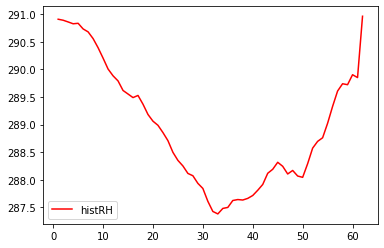

In [4]:

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), t2mD)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})

# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask

# Area Average
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh

rhTs=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=rhTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH,label='histRH', color='red')
plt.legend()

rhERA5HistMean=rhTs.groupby('time.dayofyear').mean()
rhERA5HistMean
rhERA5HistStd=rhTs.groupby('time.dayofyear').std()
rhERA5HistStd

print(rhERA5HistMean)

[278.98987 279.03506 278.84814 ... 278.4597  278.1823  278.50937]


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


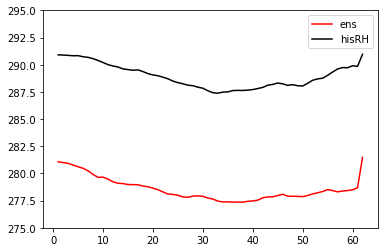

In [5]:
# IPSL

rhData  = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS


# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=ensTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH_ens=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')

plt.ylim([275, 295])
plt.legend()



In [6]:
# # Historica/ref best3 ensemble mean and std

# IPSL

rhData  = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS

ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean


[278.98987 279.03506 278.84814 ... 278.4597  278.1823  278.50937]


<xarray.DataArray 'rh' (dayofyear: 63)>
array([277.73657, 277.6492 , 277.45374, 277.37888, 277.3866 , 277.35825,
       277.37555, 277.35284, 277.43585, 277.4716 , 277.54297, 277.75833,
       277.8374 , 277.85138, 277.96622, 278.08572, 277.90366, 277.90103,
       277.89093, 277.86664, 277.96658, 278.12057, 278.21802, 278.337  ,
       278.5105 , 278.4247 , 278.3074 , 278.3811 , 278.4275 , 278.49194,
       278.68265, 281.46912, 281.07565, 281.0002 , 280.92795, 280.7655 ,
       280.61606, 280.47226, 280.23962, 279.9065 , 279.64005, 279.65918,
       279.48184, 279.22546, 279.09497, 279.06738, 278.97882, 278.97037,
       278.9563 , 278.84192, 278.77286, 278.64722, 278.50064, 278.2993 ,
       278.1057 , 278.07184, 277.99936, 277.83963, 277.813  , 277.91626,
       277.93222, 277.9033 , 277.35062], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

278.551160326191


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


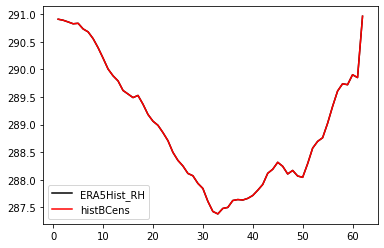

In [7]:
### Historical Bias Correction

x=np.arange(1,63)
plt.plot(x,histRH,label='ERA5Hist_RH', color='black')

# IPSL

rhData  = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[]
for c in rhTsACCESS.time:
        
    MTs.append((rhTsACCESS.sel(time=c)+rhTsIPSL.sel(time=c)+
                rhTsEC.sel(time=c))/3.0)
    
ensFu=rhTsACCESS.copy()
ensFu.values=MTs


MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensFu=rhTsACCESS.copy()
ensFu.values=MTs

ensFuMean=ensFu.groupby('time.dayofyear').mean()
ensFuStd=ensFu.groupby('time.dayofyear').std()

### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
#print(ensFuBC)
#print(ensFu)

#print(ensFuBC)
#print(cnnObs)

ensFuBCHistMean1=ensFuBC.groupby('time.dayofyear').mean()
ensFuBCHistMean2=ensFuBCHistMean1.roll(dayofyear=31)
histBCens=ensFuBCHistMean2[(ensFuBCHistMean2.dayofyear<366) | (ensFuBCHistMean2.dayofyear>366)]
plt.plot(x,histBCens,label='histBCens', color='red')
plt.legend()
plt.savefig('histEnsBCTS.eps')
plt.show()

df=ensFuBC.to_dataframe(name='histEnsBCTS')
#np.savetxt('histEnsTS.txt', df.values, fmt='%1.3f')




# Future proj

In [8]:
## CF Future
ssps=['370','585']
#ssps=['370']

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


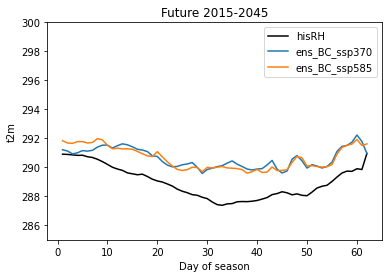

In [9]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    
plt.ylim([285, 300])
plt.legend()
plt.ylabel('t2m') 
plt.xlabel('Day of season')     
plt.title('Future 2015-2045') 
plt.savefig('T2M_2015_2045.eps')
    

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


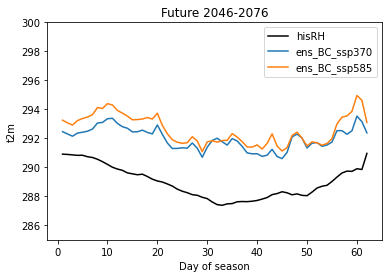

In [10]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    
plt.ylim([285, 300])
plt.legend()
plt.ylabel('t2m') 
plt.xlabel('Day of season')     
plt.title('Future 2046-2076') 
plt.savefig('T2M_2046_2076.eps')
    

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


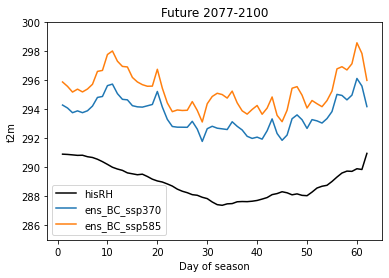

In [11]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    
plt.ylim([285, 300])
plt.legend()
plt.ylabel('t2m') 
plt.xlabel('Day of season')     
plt.title('Future 2077-2100') 
plt.savefig('T2M_2077_2100.eps')    

In [12]:
# # Historical Moisture
xhist=np.arange(1981,2019)
print(histRH_ens.time)




AttributeError: 'DataArray' object has no attribute 'time'

In [ ]:
x=np.arange(2015,2101)
#plt.plot(x,histRH_ens,label='ens', color='red')
#plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    print(ensFuBCF.time)
    
    plt.plot(x,ensFuBCF,label='ens_BC_ssp'+sp)
    
plt.ylim([285, 300])
plt.legend()
plt.ylabel('t2m') 
#plt.xlabel('Day of season')     
plt.title('Future 2015-2100') 
#plt.savefig('T2M_2015_2100.eps')    